In [2]:
pip install alpha_vantage

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
import time
import yfinance as yf
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
from keras.optimizers import Adam
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import load_model
import os
from functools import partial
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import qmc
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import shap
from alpha_vantage.timeseries import TimeSeries
from sklearn.linear_model import Lasso
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
import itertools
from tensorflow.keras.constraints import Constraint

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NNcode/
# or cd /Users/xuyunpeng/Documents/Time-consistentPlanning/cleanup_code/

Mounted at /content/drive
/content/drive/MyDrive/NNcode


In [31]:
import importlib
import functions
importlib.reload(functions)
from functions import *

In [6]:
random.seed(10)

## Macro parameter setup

Note:

All monetary units are in per 1,000,000 USD, e.g., initial_capital = 1 means the initial capital value allowed to be allocated to assets and dividends is 1,000,000 USD.

In [7]:
T = 5
num_processes = 4
start_date = "2014-01-01" # can change
end_date = "2023-04-30"
numTrain = 2**10
numSim = numTrain
initial_capital = 1
gamma = 0.4
rdr = 0.06 # annual risk discount rate
rdr_monthly = (1+rdr)**(1/12) -1
v = 1/(1+rdr_monthly)
stock_lo, stock_up = 0.00, 0.10
cbond_lo, cbond_up = 0.55, 0.85
div_up = 0.05
div_lo = 0



## Dir

In [8]:
directory = '/content/drive/MyDrive/NNcode'

## VARIMA model: Claim Data

Assume the company's whole life policy portfolio includes 0.1% of total counts of death resulted from all causes in the US, and this policy exsited in the market since 2012.

The death benefit is USD 1,000 for all policy.

Counts of death data is obtainable from [this link](https://data.un.org/Data.aspx?d=POP&f=tableCode:65;countryCode:840;areaCode=0#:~:text=United%20States%20of%20America%202019,tabulated%20by%20year%20of%20occurrence) from year 2000 to 2019, and provisional counts of death data is obtainable from [here](https://data.cdc.gov/NCHS/Monthly-Provisional-Counts-of-Deaths-by-Select-Cau/9dzk-mvmi/about_data)
from year 2020 to 2023.
The two datasets are combined to obtain the `CountOfDeath_2000-2023.csv`.

In [9]:
death_data = pd.read_csv('CountOfDeath_2000-2023.csv')
death_data['Date'] = pd.to_datetime(death_data['Date'])
death_data.set_index('Date', inplace=True)
death_data = death_data[start_date:end_date]

# First multiply by 0.001 to get the number of deaths.
# Each death costs 1,000 USD, so multiply by 1,000. But the units are in 1,000,000, so need to divide by 1,000,000.
death_data['Deaths'] *= 0.001*1000/1000000

print(death_data)
p = np.mean(death_data) * 1.2
print('premium rate at loading of 1.2 is ', p)

              Deaths
Date                
2014-01-01  0.243298
2014-02-01  0.211980
2014-03-01  0.228477
2014-04-01  0.215600
2014-05-01  0.216862
...              ...
2022-12-01  0.301278
2023-01-01  0.289362
2023-02-01  0.249084
2023-03-01  0.269173
2023-04-01  0.251959

[112 rows x 1 columns]
premium rate at loading of 1.2 is  0.2978729678571428


/tmp/ipython-input-9-1200536231.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_data['Deaths'] *= 0.001*1000/1000000


## VARIMA Model: Asset price data

As discussed in the work, we assume the insurer invests its capital into corporate bonds, government bonds, and stocks.

Here we picked `VYM` as a representative for stocks, `HYG` for corporate bonds, and `TIP` for government bonds.

In [10]:
portfolio = ['SPY', 'HYG', 'TIP']
API_KEY = "3VNUSSWK4AQPWMMD"
ts = TimeSeries(key=API_KEY, output_format="pandas")
data_frames = []
for stock in portfolio:
    stock_data, meta_data = ts.get_daily(symbol=stock, outputsize="full")
    stock_data = stock_data[['4. close']]
    stock_data.columns = [stock]
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data = stock_data.sort_index()
    stock_data = stock_data.loc[start_date:end_date]
    stock_data = stock_data.resample('MS').first()
    data_frames.append(stock_data)
    time.sleep(15)

In [11]:
S = pd.concat(data_frames, axis=1, join="inner")
S = S.apply(pd.to_numeric)
S = S.dropna()
ln_S = np.log(S)
d_ln_S = np.diff(ln_S, axis=0)

combined = pd.concat([S, death_data], axis=1, join="inner").dropna()
combined.columns = portfolio + ['claim']

ln_combined = np.log(combined)
ln_combined.to_csv("ln_x.csv")
print(ln_combined)

d_ln_combined = ln_combined.diff().dropna()
d_ln_combined.to_csv("d_ln_x.csv")
d_ln_L = d_ln_combined['claim']
print(d_ln_combined)

                 SPY       HYG       TIP     claim
2014-01-01  5.209049  4.533030  4.702841 -1.413468
2014-02-01  5.160032  4.527317  4.726237 -1.551263
2014-03-01  5.220248  4.547329  4.729333 -1.476320
2014-04-01  5.237771  4.544571  4.715906 -1.534330
2014-05-01  5.238196  4.541378  4.733827 -1.528494
...              ...       ...       ...       ...
2022-12-01  6.009746  4.325721  4.694737 -1.199722
2023-01-01  5.942327  4.300952  4.671145 -1.240077
2023-02-01  6.018106  4.340684  4.694828 -1.389965
2023-03-01  5.978227  4.302307  4.670771 -1.312401
2023-04-01  6.018472  4.319486  4.703385 -1.378489

[112 rows x 4 columns]
                 SPY       HYG       TIP     claim
2014-02-01 -0.049017 -0.005713  0.023396 -0.137795
2014-03-01  0.060216  0.020012  0.003096  0.074944
2014-04-01  0.017523 -0.002759 -0.013427 -0.058011
2014-05-01  0.000425 -0.003193  0.017921  0.005836
2014-06-01  0.023976  0.005315  0.006486 -0.057779
...              ...       ...       ...       ...
2022-12

## Fitting a VARIMA(2,1,0) model create training data and testing sample paths


### Fitting VARIMA

In [12]:
# d_ln_x_data = pd.read_csv('/content/drive/MyDrive/NNcode/d_ln_x.csv', index_col=0)
d_ln_x_data = pd.read_csv('d_ln_x.csv', index_col=0)
d_ln_x_data = d_ln_x_data.apply(pd.to_numeric)

Phi_metrics, mu, Sigma = lasso_VAR_centered(p=2, data=d_ln_x_data, alpha=0.0001)
Phi1 = Phi_metrics[0]
Phi2 = Phi_metrics[1]
mu = mu.flatten()
print(Phi1)
print(Phi2)
print(mu)
print(Sigma)

[[-0.18965103 -0.04729712 -0.          0.06633563]
 [-0.         -0.00738822 -0.         -0.        ]
 [ 0.          0.         -0.          0.        ]
 [ 0.          0.00074771  0.01341214 -0.11941617]]
[[-0.08384058 -0.          0.         -0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.         -0.          0.         -0.32088715]
 [ 0.05218678  0.03169654  0.         -0.12497824]]
[ 7.29209598e-03 -1.92381434e-03  4.90108400e-06  3.15129247e-04]
[[ 2.18968666e-03  9.53175388e-04  2.26949739e-04 -4.37100789e-04]
 [ 9.53175388e-04  6.07298641e-04  1.61738320e-04 -3.50783516e-04]
 [ 2.26949739e-04  1.61738320e-04  2.12757901e-04 -8.24539489e-05]
 [-4.37100789e-04 -3.50783516e-04 -8.24539489e-05  6.02481920e-03]]


###Quantization Grid

In [13]:
# directory = '/Users/xuyunpeng/Documents/Time-consistentPlanning/cleanup_code/'

file_path = '300_4_nopti'

df = pd.read_csv(file_path, sep='\s+', header=None)

weights = df.iloc[:, 0].values
quant_knots_std = df.iloc[:, 1:5].values

L = np.linalg.cholesky(Sigma)
quant_knots = quant_knots_std @ L.T

T = 5
N, d = quant_knots.shape

quantize_grid = np.zeros((T+1, N, d))
quantize_grid[1:] = np.tile(quant_knots[None, :, :], (T, 1, 1))

l = weights

### Testing and Validation sample paths

In [14]:
numTest = numSim


# d ln(x_t) sample paths

d_ln_S1_0, d_ln_S1_minus1 = d_ln_x_data.iloc[-1,0], d_ln_x_data.iloc[-2,0]
d_ln_S2_0, d_ln_S2_minus1 = d_ln_x_data.iloc[-1,1], d_ln_x_data.iloc[-2,1]
d_ln_S3_0, d_ln_S3_minus1 = d_ln_x_data.iloc[-1,2], d_ln_x_data.iloc[-2,2]
d_ln_L_0, d_ln_L_minus1 = d_ln_x_data.iloc[-1,3], d_ln_x_data.iloc[-2,3]

current_x = np.array([d_ln_S1_0, d_ln_S2_0, d_ln_S3_0, d_ln_L_0])
last_x = np.array([d_ln_S1_minus1, d_ln_S2_minus1, d_ln_S3_minus1, d_ln_L_minus1])

noise_vali, d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali = VARMA_sim1( current_x, last_x, Sigma, numSim, T, mu, Phi1, Phi2)
noise_test, d_ln_S1_test, d_ln_S2_test, d_ln_S3_test, d_ln_L_test = VARMA_sim1( current_x, last_x,  Sigma, numSim, T, mu, Phi1, Phi2)


# d ln(x_{t-1}) sample paths

d_ln_S1t_minus1_vali = np.zeros((numSim, T+1))
d_ln_S2t_minus1_vali = np.zeros((numSim, T+1))
d_ln_S3t_minus1_vali = np.zeros((numSim, T+1))
d_ln_Lt_minus1_vali  = np.zeros((numSim, T+1))

d_ln_S1t_minus1_vali[:, 0] = d_ln_S1_minus1
d_ln_S2t_minus1_vali[:, 0] = d_ln_S2_minus1
d_ln_S3t_minus1_vali[:, 0] = d_ln_S3_minus1
d_ln_Lt_minus1_vali[:, 0]  = d_ln_L_minus1

d_ln_S1t_minus1_vali[:, 1:] = d_ln_S1_vali[:, :T]
d_ln_S2t_minus1_vali[:, 1:] = d_ln_S2_vali[:, :T]
d_ln_S3t_minus1_vali[:, 1:] = d_ln_S3_vali[:, :T]
d_ln_Lt_minus1_vali[:, 1:]  = d_ln_L_vali[:, :T]

### Determining the upper and lower bound of $C$

In [15]:
ln_L_0 = ln_combined.iloc[3, -1]
ln_L_vali = ln_L_0 + np.cumsum(d_ln_L_vali[:, 1:T+1], axis=1)
L_vali = np.exp(ln_L_vali)

R1 = np.exp(d_ln_S1_vali[:, 1:T+1])
R2 = np.exp(d_ln_S2_vali[:, 1:T+1])
R3 = np.exp(d_ln_S3_vali[:, 1:T+1])

max_return = np.max(np.max(np.stack([R1, R2, R3]), axis=0), axis = 0)
min_return = np.min(np.min(np.stack([R1, R2, R3]), axis=0), axis = 0)

max_L = np.max(L_vali, axis=0)
min_L = np.min(L_vali, axis=0)

c_max, c_min = 0.0, 0.0
for t in range(T):
    c_max = (initial_capital + p - div_lo * c_max) * max_return[t] - min_L[t]
    c_min = (initial_capital + p - div_up * c_min) * min_return[t] - max_L[t]

print(c_max,c_min)

1.415878064504441 0.70460300142339


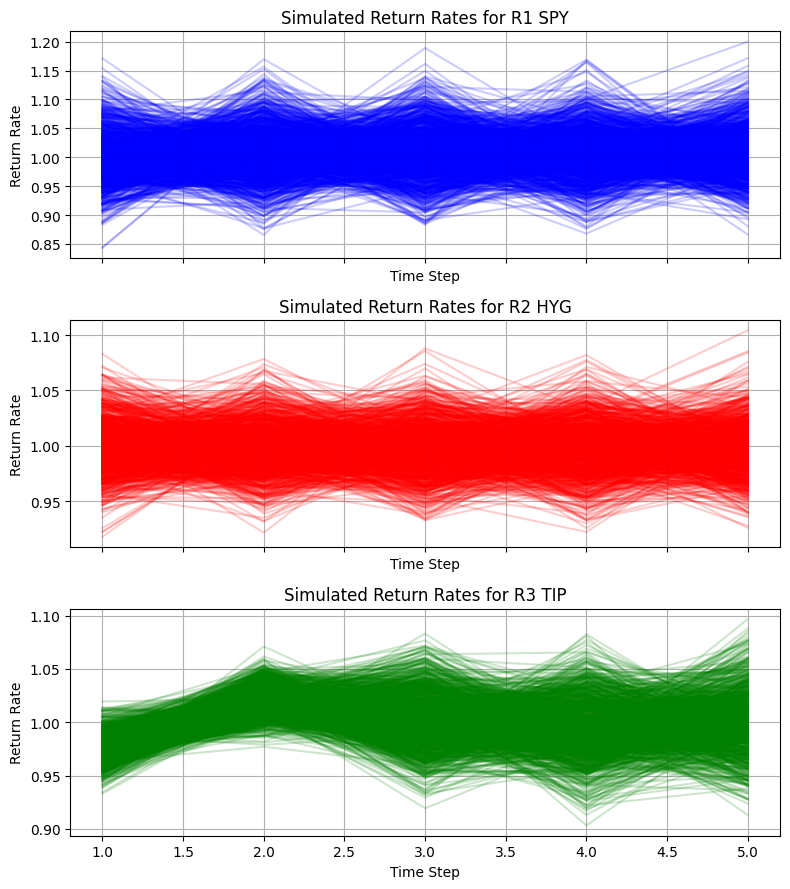

In [16]:
time_steps = range(1, T+1)
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

for i in range(numSim):
    axs[0].plot(time_steps, R1[i, :], 'b-', alpha=0.2)
    axs[1].plot(time_steps, R2[i, :], 'r-', alpha=0.2)
    axs[2].plot(time_steps, R3[i, :], 'g-', alpha=0.2)

axs[0].set_title('Simulated Return Rates for R1 ' + portfolio[0])
axs[1].set_title('Simulated Return Rates for R2 ' + portfolio[1])
axs[2].set_title('Simulated Return Rates for R3 ' + portfolio[2])

for ax in axs:
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Return Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Training Data

In [17]:
d_ln_S1t_train, d_ln_S1t_minus1_train, \
d_ln_S2t_train, d_ln_S2t_minus1_train, \
d_ln_S3t_train, d_ln_S3t_minus1_train, \
d_ln_Lt_train,  d_ln_Lt_minus1_train, \
ln_Lt_train, c_train = generate_training_data(
    d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali,
    ln_L_vali, (c_min, c_max), numTrain, T
)

In [18]:
train_df = pd.DataFrame({
    'd_ln_S1t': d_ln_S1t_train,
    'd_ln_S1t_minus1': d_ln_S1t_minus1_train,
    'd_ln_S2t': d_ln_S2t_train,
    'd_ln_S2t_minus1': d_ln_S2t_minus1_train,
    'd_ln_S3t': d_ln_S3t_train,
    'd_ln_S3t_minus1': d_ln_S3t_minus1_train,
    'd_ln_Lt': d_ln_Lt_train,
    'd_ln_Lt_minus1': d_ln_Lt_minus1_train,
    'ln_Lt': ln_Lt_train,
    'c': c_train
})

print(train_df.describe())         # Min, max, mean, etc.

          d_ln_S1t  d_ln_S1t_minus1     d_ln_S2t  d_ln_S2t_minus1  \
count  1024.000000      1024.000000  1024.000000      1024.000000   
mean      0.005760         0.005760    -0.002958        -0.002958   
std       0.101999         0.101999     0.059027         0.059027   
min      -0.170724        -0.170662    -0.104964        -0.105004   
25%      -0.082509        -0.082353    -0.053950        -0.054051   
50%       0.005728         0.005724    -0.002937        -0.002967   
75%       0.094010         0.093921     0.048067         0.048121   
max       0.182181         0.182256     0.099090         0.099106   

          d_ln_S3t  d_ln_S3t_minus1      d_ln_Lt  d_ln_Lt_minus1        ln_Lt  \
count  1024.000000      1024.000000  1024.000000     1024.000000  1024.000000   
mean      0.000902         0.000902     0.039087        0.039087    -1.450222   
std       0.067460         0.067460     0.188212        0.188212     0.291435   
min      -0.115886        -0.115821    -0.286150      

## Training prep


In [28]:

class NonNegative(Constraint):
    def call(self, inputs):
        w_pos = tf.math.softplus(self.kernel)
        return tf.matmul(inputs, w_pos) + self.bias

def custom_loss(y_true, y_pred):
    value_loss = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))
    control_loss = tf.reduce_mean(tf.square(y_true[:, 1:] - y_pred[:, 1:]))
    return value_loss + 1*control_loss

def activat_func(x):
    return -tf.math.softplus(-x)

## Main Training

In [33]:

def BuildAndTrainModel(
                       d_ln_S1t_train, d_ln_S2t_train, d_ln_S3t_train, d_ln_Lt_train,
                       d_ln_S1t_minus1_train, d_ln_S2t_minus1_train, d_ln_S3t_minus1_train, d_ln_Lt_minus1_train,
                       ln_Lt_train, c1_train,
                       quantizer, quantize_weights, v, validation_ratio=0.1
                       ):

    nn_dim = 10
    node_num = 40
    batch_num = 64
    epoch_num = 500
    initializer_C = tf.keras.initializers.RandomUniform(minval=0.01, maxval=0.1, seed=0)
    initializer_others = tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=0)

    input_train = np.concatenate([
                                 d_ln_S1t_train.reshape(-1,1), d_ln_S2t_train.reshape(-1,1), d_ln_S3t_train.reshape(-1,1), d_ln_Lt_train.reshape(-1,1),
                                 d_ln_S1t_minus1_train.reshape(-1,1), d_ln_S2t_minus1_train.reshape(-1,1), d_ln_S3t_minus1_train.reshape(-1,1), d_ln_Lt_minus1_train.reshape(-1,1),
                                 ln_Lt_train.reshape(-1,1), c1_train.reshape(-1,1)],
                                 axis=1
                                 )

    # amplification = np.array([1.0]*10)
    input_train_amplified = input_train #* amplification
    input_scaler = StandardScaler()
    input_train_scaled = input_scaler.fit_transform(input_train_amplified)

    train_cutoff = int((1 - validation_ratio) * numTrain)
    numValid = numTrain - train_cutoff

    V_train = np.zeros((T+1, numTrain))
    u_train = np.zeros((T+1, numTrain, 3))
    target_train = np.zeros((T+1, numTrain, 4))  # 1 for value, 3 for controls
    V_valid = np.zeros((T+1, numValid))
    u_valid = np.zeros((T+1, numValid, 3))
    target_valid = np.zeros((T+1, numValid, 4))  # 1 for value, 3 for controls

    output_scaler = np.empty(T+1, dtype=object)
    V_hat_theta = np.empty(T+1, dtype=object)

    start = time.perf_counter()

    for t in range(T-1, 0, -1):
        start_i = time.perf_counter()
        print("Time step " + str(t))

        best_u12 = [(stock_lo + stock_up) / 2, (cbond_lo + cbond_up) / 2]  # warm-start seed (mutable list)

        for j in range(numTrain):

            if t < (T-1):
                def j_v_t(u):
                    value = V_t(
                                 d_ln_S1t_train[j], d_ln_S2t_train[j], d_ln_S3t_train[j], d_ln_Lt_train[j],
                                 d_ln_S1t_minus1_train[j], d_ln_S2t_minus1_train[j], d_ln_S3t_minus1_train[j], d_ln_Lt_minus1_train[j],
                                 ln_Lt_train[j], c1_train[j],
                                 u, mu, Phi1, Phi2, p,
                                 V_hat_theta[t+1].get_weights(), input_scaler, output_scaler[t+1], quantizer, t,
                                 l, gamma, v
                                 )
                    return value *-1

            else:
                def j_v_t(u):
                    value = V_T_minus1(
                                       d_ln_S1t_train[j], d_ln_S2t_train[j], d_ln_S3t_train[j], d_ln_Lt_train[j],
                                       d_ln_S1t_minus1_train[j], d_ln_S2t_minus1_train[j], d_ln_S3t_minus1_train[j], d_ln_Lt_minus1_train[j],
                                       ln_Lt_train[j], c1_train[j],
                                       u, mu, Phi1, Phi2, p,
                                       l, gamma, v, quantizer
                                       )
                    return value *-1

            u_star, jv_min, best_u12 = optimize_u_general(
                t=t,
                quantize_weights=quantize_weights,
                g=g,
                j_v_t=j_v_t,
                d_ln_S1t=d_ln_S1t_train[j], d_ln_S2t=d_ln_S2t_train[j], d_ln_S3t=d_ln_S3t_train[j], d_ln_Lt=d_ln_Lt_train[j],
                d_ln_S1t_minus1=d_ln_S1t_minus1_train[j], d_ln_S2t_minus1=d_ln_S2t_minus1_train[j],
                d_ln_S3t_minus1=d_ln_S3t_minus1_train[j], d_ln_Lt_minus1=d_ln_Lt_minus1_train[j],
                ln_Lt=ln_Lt_train[j], C_t=c1_train[j],
                mu=mu, Phi1=Phi1, Phi2=Phi2, p=p, quantizer=quantizer,
                stock_lo=stock_lo, stock_up=stock_up,
                cbond_lo=cbond_lo, cbond_up=cbond_up,
                div_lo=div_lo, div_up=div_up,
                best_u12=best_u12
            )

            if j < int((1-validation_ratio)*numTrain):
                V_train[t, j] = -jv_min
                u_train[t, j, :] = u_star
                target_train[t, j, :] = [-jv_min, *u_star]
            else:
                j2 = j - train_cutoff
                V_valid[t, j2] = -jv_min
                u_valid[t, j2, :] = u_star
                target_valid[t, j2, :] = [-jv_min, *u_star]

        assert V_train[t].size > 0 and np.std(V_train[t]) != 0

        end_i = time.perf_counter()
        print("     all optimizations done: " + str(round((end_i-start_i)/60, 2)) + " min.")

        output_scaler[t] = MinMaxScaler(feature_range=(0, 1))
        output_scaler[t].fit(target_train[t, :, 0].reshape(-1, 1))
        target_train_scaled = target_train[t].copy()
        target_train_scaled[:, 0] = output_scaler[t].transform(target_train[t, :, 0].reshape(-1, 1)).flatten()

        input_layer = Input(shape=(nn_dim,))
        input_others = input_layer[:, :-1]
        input_C = input_layer[:, -1:]
        free_layer = Dense(node_num, activation='tanh', kernel_initializer=initializer_C)(input_others)
        free_layer = Dense(node_num, activation='tanh', kernel_initializer=initializer_C)(free_layer)
        free_layer = Dense(node_num, activation='tanh', kernel_initializer=initializer_C)(free_layer)
        free_layer = Dense(node_num, activation='tanh', kernel_initializer=initializer_C)(free_layer)
        C_layer = Dense(node_num, activation=activat_func,
                        kernel_initializer=initializer_C,
                        kernel_constraint=NonNegative())(input_C)
        merged = Concatenate()([free_layer, C_layer])
        final_layer = Dense(node_num, activation=activat_func,
                            kernel_initializer=initializer_C,
                            kernel_constraint=NonNegative())(merged)
        output_layer = Dense(4, kernel_initializer=initializer_C,
                            kernel_constraint=NonNegative())(final_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss)

        train_start = time.perf_counter()
        model.fit(input_train_scaled, target_train_scaled, epochs=epoch_num, batch_size=batch_num, verbose=0)
        train_end = time.perf_counter()
        print(f"     Training time: {round((train_end - train_start)/60, 2)} min.")

        V_hat_theta[t] = model
        pred_scaled = model.predict(input_train_scaled)
        mse_valuefun = mean_squared_error(target_train_scaled[:train_cutoff, 0], pred_scaled[:train_cutoff, 0])
        mse_all = mean_squared_error(target_train_scaled[:train_cutoff, :], pred_scaled[:train_cutoff, :])
        print(f"     Training MSE (V only): {mse_valuefun}, Training MSE (all): {mse_all}")

        valid_input = input_train_scaled[train_cutoff:]
        target_valid_scaled = target_valid[t].copy()
        target_valid_scaled[:, 0] = output_scaler[t].transform(target_valid[t, :, 0].reshape(-1, 1)).flatten()
        pred_valid_scaled = model.predict(valid_input, verbose=0)
        mse_valid_valuefun = mean_squared_error(target_valid_scaled[:, 0], pred_valid_scaled[:, 0])
        mse_valid_all = mean_squared_error(target_valid_scaled[:, :], pred_valid_scaled[:, :])
        print(f"     Validation MSE (value only): {mse_valid_valuefun}, Validation MSE (all): {mse_valid_all}")

    print("Duration: " + str((time.perf_counter() - start) / 60) + " min.")
    return V_hat_theta, input_scaler, output_scaler, V_train, u_train

To avoid approximating the control as a function of state variables, we surrogate the value function directly, and optimize it per sample path to obtain the optimal control for that sample path for a particular problem.

After realizing the value function barely reacts to the state variables other than $C$, gpt suggested a 2 head (terminal node) NN.

The NN has shared layers, one terminal node is for the value function, and one is for the optimal control. In the shared layers, the weights and biases are the same for value function node and control node.

This is different from the authors' approach, where the NN strcuture (no. of layers, nodes, etc.) are shared, but not the layers. The key weakness of the authors' approach on training value function is that when one state variable is dominating the value function, it is possible that the NN only 'learnt' the dominating state variable while completely ignoring the others.

The regression tasks are not conflicting with each other, as the training MSE did not change by much. the control head serves as the auxillary head that enforces the shared layers to 'see' the state variables other than $C$, which in our case are the prices. Hence, the NN is learnt not only the $C$, but all state variables that are related to the policy.



In [34]:
# V_hat_theta, in_scaler, out_scaler , u_hat_theta_cbond, u_hat_theta_gbond, u_hat_theta_stketf, u_hat_theta_divid\

V_hat_theta, in_scaler, out_scaler, V_train, u_train\
= BuildAndTrainModel(c_train,
                    d_ln_S1t_train, d_ln_S2t_train, d_ln_S3t_train, d_ln_Lt_train,
                    d_ln_S1t_minus1_train, d_ln_S2t_minus1_train, d_ln_S3t_minus1_train, d_ln_Lt_minus1_train,
                    ln_Lt_train,
                    quantize_grid, weights, v)

Time step 4
     all optimizations done: 0.05 min.
     Training time: 0.67 min.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
     Training MSE (V only): 0.010135208582140382, Training MSE (all): 0.00954171583681673
     Validation MSE (value only): 0.010350895815452784, Validation MSE (all): 0.009554888622467318
Time step 3
     all optimizations done: 0.92 min.
     Training time: 0.71 min.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
     Training MSE (V only): 0.01149330317468661, Training MSE (all): 0.01015892795643845
     Validation MSE (value only): 0.01172157055018215, Validation MSE (all): 0.01022193077403572
Time step 2
     all optimizations done: 0.92 min.
     Training time: 0.67 min.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
     Training MSE (V only): 0.011693133472359169, Training MSE (all): 0.010449976621375449
     Validation MSE (value only): 0.011917190872396368, Validation MSE (all): 0.010524875464819217
Time step 1
     all optimizations done: 0.94 min.
     Training time

## SHAP

`ExactExplainer` computes the shapley values for state variable $i$ for a specific $\boldsymbol{y}$.

Let $|\boldsymbol{y}|=M$ which $M=10$ in our case. $\Pi$ is the set of all possible permutations of indices for $1,2,...,M$, thus $|\Pi|=M!$.

Let $A_i^{(\pi)}$ be the subset of the $\pi$-th element of $\Pi$ comprised of the indices before $i$. This subset represents a specific 'context' to evaluate the 'marginal contribution' of state variable $i$.  

Let $\boldsymbol{y}_{[A_i^{(\pi)}]}$ be a subvector of that specific $\boldsymbol{y}$ with the indices in $A_i^{(\pi)}$.

Note, the state variables at indices that are not included in $A_i^{(\pi)}$ are set to be baseline values, and in `shap.Explainer`, it is set to be the (training) sample average of that state variable, i.e. $\frac{1}{N}\sum {}^{j}\boldsymbol{y}, N\leq n$.

The shapley value are computed as below:

$$
\phi_i(\mathring{V}^{ \hat \theta_t}, \boldsymbol{y}) = \frac{1}{M!} \sum_{\pi \in \Pi} \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}\cup \{i\}]}) - \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}]}).
$$

This is $\phi_i$ calculating the average marginal value of output of including state variable $i$ across all possible scenarios where $i$ is added to some subset of the other $M-1$ variables.

In $\mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}\cup \{i\}]}) - \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}]})$, this difference represents how much variable $i$ changes the model output within that specific context $\pi$. By averaging this quantity over all $M!$ permutations of context, we effectively consider every possible subset of variables to which $i$ could be added, and how much it would impact the function's value in each context. This ensures that the final Shapley value $\phi_i$ is fair and context-aware, accounting for feature interactions and dependencies in a principled way.

For a specific ${}^{j}\boldsymbol{y}$, we can compute a ${}^{j}\phi_i$, and plotting the values we get the below plots.


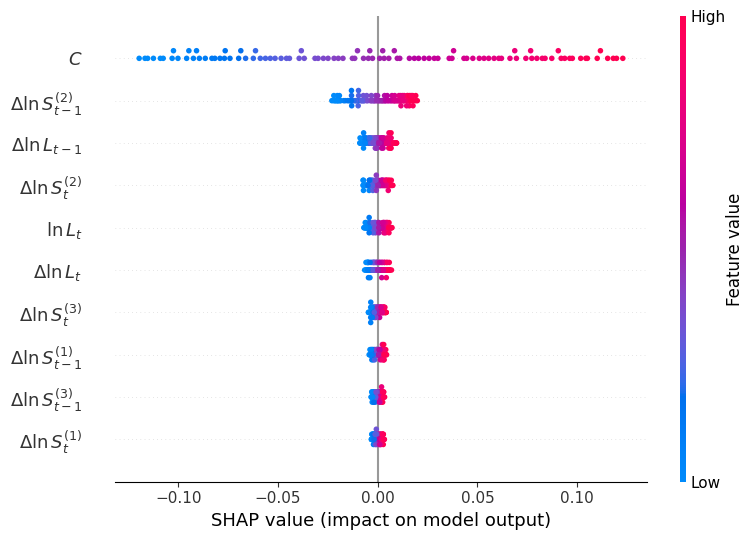

<class 'shap.explainers._exact.ExactExplainer'>


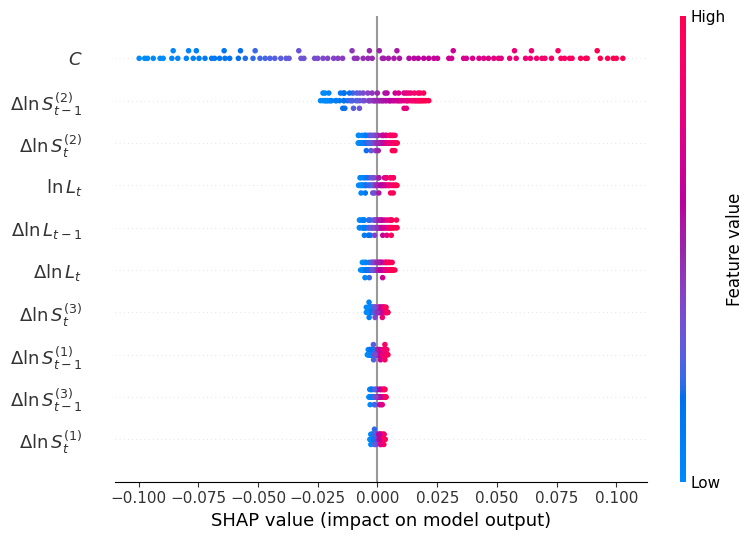

<class 'shap.explainers._exact.ExactExplainer'>


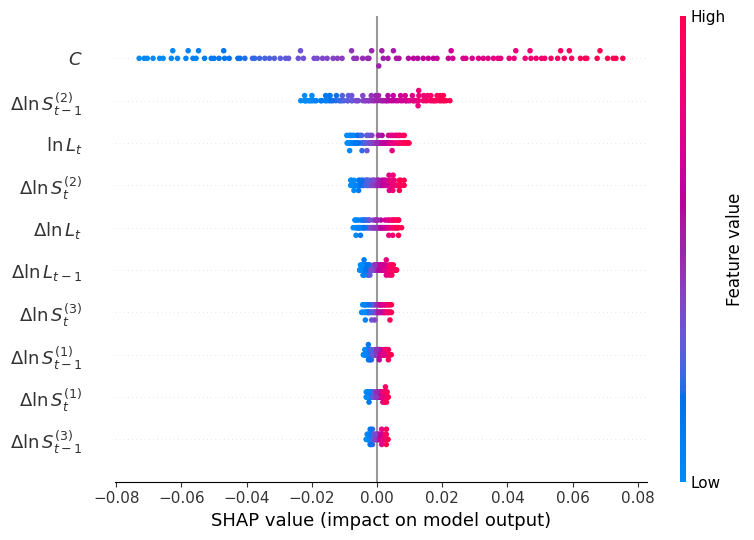

<class 'shap.explainers._exact.ExactExplainer'>


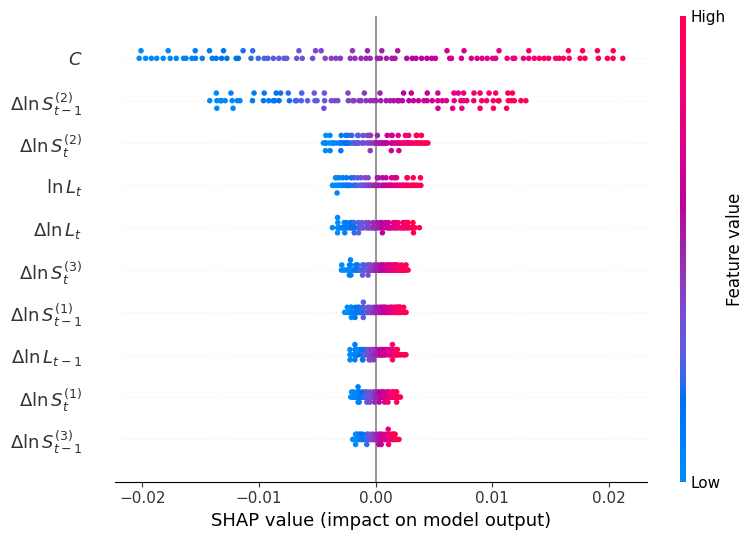

<class 'shap.explainers._exact.ExactExplainer'>


In [35]:
from tensorflow.keras.layers import Lambda

input_train = np.concatenate((
                                d_ln_S1t_train.reshape(-1,1),
                                d_ln_S2t_train.reshape(-1,1),
                                d_ln_S3t_train.reshape(-1,1),
                                d_ln_Lt_train.reshape(-1,1),
                                d_ln_S1t_minus1_train.reshape(-1,1),
                                d_ln_S2t_minus1_train.reshape(-1,1),
                                d_ln_S3t_minus1_train.reshape(-1,1),
                                d_ln_Lt_minus1_train.reshape(-1,1),
                                ln_Lt_train.reshape(-1,1),
                                c_train.reshape(-1,1)
                                ), axis = 1)
input_data_scaled = in_scaler.transform(input_train)
state_variables = [
    '$\\Delta \\ln S^{(1)}_t$', '$\\Delta \\ln S^{(1)}_{t-1}$',
    '$\\Delta \\ln S^{(2)}_t$', '$\\Delta \\ln S^{(2)}_{t-1}$',
    '$\\Delta \\ln S^{(3)}_t$', '$\\Delta \\ln S^{(3)}_{t-1}$',
    '$\\Delta \\ln L_t$',  '$\\Delta \\ln L_{t-1}$',
    '$\\ln L_t$', '$C$',
]
input_df = pd.DataFrame(input_data_scaled[:100], columns=state_variables) # N=100

for s in range(T-1):
    t = s+1
    value_output_only = Lambda(lambda x: x[:, 0:1])(V_hat_theta[t].output)
    value_model = Model(inputs=V_hat_theta[t].input, outputs=value_output_only)
    explainer = shap.Explainer(value_model, input_df)
    shap_values = explainer(input_df)
    shap.summary_plot(shap_values.values, input_df)
    print(type(explainer))

should be reasonable to see S2 being more influential, because S1 and S3 have very narrow bounds, stock_lo and stock_up made a small interval for S1 to actually craete an impact.

The SHAP summary plot reveals that the neural network’s value function is primarily driven by two key variables: $\ln L_t$ (log liability at time $t$) and $C_t$ (capital at time $t$). This is entirely intuitive. A higher $\ln L_t$ represents more liability and thus reduces net worth, which directly lowers the utility of both immediate and future payouts. In contrast, a larger $C_t$ increases both the immediate payout potential and future compounding ability, thus raising expected utility. These two variables dominate the model’s decisions.

Beyond these direct effects, we see that $\Delta \ln L_{t-1}$ (the one-period lagged liability return) also plays a notable role in the SHAP plot. This makes sense in light of the underlying VAR(2) structure of the liability equation:

\begin{align*}
\Delta \ln L_t &= 0.00083
+ 0.00558 \cdot (\Delta \ln S^{(3)}_{t-1} + 0.00041)
- 0.16387 \cdot (\Delta \ln L_{t-1} - 0.00083) \\
&\quad + 0.03034 \cdot (\Delta \ln S^{(1)}_{t-2} - 0.00626)
+ 0.03297 \cdot (\Delta \ln S^{(2)}_{t-2} + 0.00131) \\
&\quad + 0.00076 \cdot (\Delta \ln S^{(3)}_{t-2} + 0.00041)
- 0.09142 \cdot (\Delta \ln L_{t-2} - 0.00083)
+ \varepsilon_t^{(L)}
\end{align*}

$\Delta \ln L_{t-1}$  has the largest absolute value of coefficient, and we can see that when $\Delta \ln L_{t-1}$ increases, $\Delta \ln L_{t}$ decreases, therefore they show reverse relationship in the SHAP plot. Beside its own autoregression, $\Delta \ln S^{(2)}_t$ has the greatest influence on $\Delta \ln L_{t}$.

Here, $\Delta \ln L_{t-1}$ has a large negative autoregressive coefficient, meaning that if liability grew large in the previous period, it's expected to reduce in the current period. This explains the reverse relationship seen in SHAP. Also, increases in past liability growth reduce future liability, which is favorable, so they positively impact the value function.

Another interesting feature is $\Delta \ln S^{(2)}_{t-1}$ (lagged return on asset 2). Even though the equation for $\Delta \ln S^{(2)}_t$ is just white noise, the NN may still find structure in its lag

???

possibly due its indirect effects via $\Delta \ln L_t$: $\Delta \ln S^{(2)}_{t-2}$ has the second largest absolute value of coefficient, suggesting that  influence forward liability movement

???

## Testing

In [36]:
results_vali, total_loss_count_vali = RunTests(initial_capital, T,
                                                ln_L_0,
                                                d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali,
                                                d_ln_S1t_minus1_vali, d_ln_S2t_minus1_vali, d_ln_S3t_minus1_vali, d_ln_Lt_minus1_vali,
                                                quantize_grid, p, l, gamma, v, mu, Phi1, Phi2,
                                                div_lo, div_up, stock_lo, stock_up, cbond_lo, cbond_up,
                                                in_scaler, out_scaler, V_hat_theta,
                                                numTest
                                                )

25% done: 0.95 min.
50% done: 1.93 min.
75% done: 2.9 min.
Duration: 3.8552691424666667 min.


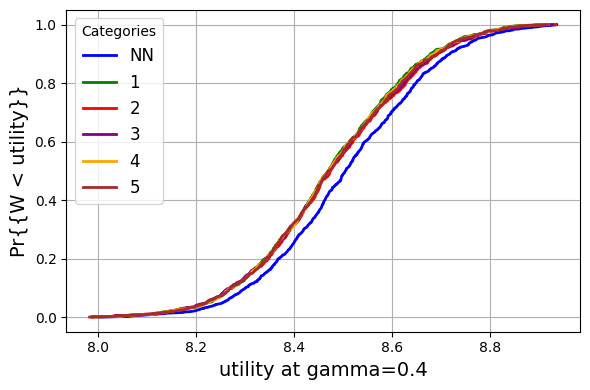

,Mean,Median,Std Dev,Pr(W_NN < W_i)
Strategy,,,,
NN,8.509484,8.505306,0.161631,/
1,8.475169,8.470313,0.158226,0.059687
2,8.481788,8.475199,0.162983,0.101761
3,8.478760,8.472099,0.162488,0.066536
4,8.476996,8.471277,0.159308,0.054795
5,8.478435,8.471478,0.160641,0.073386


In [37]:
W_all = { 'NN': [], '1': [], '2': [], '3': [], '4': [], '5': [] }

for path in results_vali:
    for i, key in enumerate(W_all.keys()):
        if key == 'NN':
            idx = 0
        else:
            idx = int(key)

        C_T = results_vali[path][idx][4][T]
        u_0_ = results_vali[path][0][5]
        C_ = results_vali[path][idx][4]

        total_utility = U(C_T, gamma) * v**T + sum([
            v**t * U(u_0_[t] * C_[t], gamma) for t in range(T)
        ])
        W_all[key].append(total_utility)

def compute_ecdf(data):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf

plt.figure(figsize=(6, 4))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for i, (label, color) in enumerate(zip(W_all.keys(), colors)):
    sorted_vals, ecdf_vals = compute_ecdf(W_all[label])
    plt.plot(sorted_vals, ecdf_vals, label=label, color=color, linewidth=2)

plt.xlabel(f'utility at gamma={gamma}', fontsize=14)
plt.ylabel('Pr{{W < utility}}', fontsize=14)
plt.legend(title='Categories', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

W_nn = W_all['NN']

summary_stats = {
    "Strategy": list(W_all.keys()),
    "Mean": [np.mean(W_all[k]) for k in W_all],
    "Median": [np.median(W_all[k]) for k in W_all],
    "Std Dev": [np.std(W_all[k]) for k in W_all],
    "Pr(W_NN < W_i)": ['/'] + [np.mean(np.array(W_nn) < np.array(W_all[key])) for key in list(W_all.keys())[1:]]
}
df_summary = pd.DataFrame(summary_stats)
df_summary = df_summary.set_index("Strategy")
display(df_summary)


In [38]:
some_paths = [random.randint(1, numTest-1) for _ in range(5)]

for some in range(1,len(some_paths)):
    print('')
    print(f'for tested path no.{some}')
    for t in range(1,T):
        print(
             f'u_t={t}: ', round(results_vali[some_paths[some]][0][0][t],4),round(results_vali[some_paths[some]][0][1][t],4), round(results_vali[some_paths[some]][0][2][t],4), round(results_vali[some_paths[some]][0][3][t],7),
             f'L_t={t} : ', round(np.exp((ln_L_0) + sum((d_ln_L_vali[some_paths[some], j]) for j in range(1, t))),4),
             f'C_t={t} : ', round(results_vali[some_paths[some]][0][4][t],2),
             round(U(results_vali[some_paths[some]][0][4][t],gamma),2)
              )



for tested path no.1
u_t=1:  0.0007 0.0 0.55 0.45 L_t=1 :  0.2156 C_t=1 :  2.93 3.84
u_t=2:  0.0007 0.0 0.55 0.45 L_t=2 :  0.1984 C_t=2 :  4.9 4.72
u_t=3:  0.0007 0.0 0.55 0.45 L_t=3 :  0.1954 C_t=3 :  7.06 5.46
u_t=4:  0.0007 0.0522 0.55 0.397845 L_t=4 :  0.1861 C_t=4 :  9.02 6.03

for tested path no.2
u_t=1:  0.0007 0.0 0.55 0.45 L_t=1 :  0.2156 C_t=1 :  2.87 3.81
u_t=2:  0.0007 0.1 0.55 0.35 L_t=2 :  0.2065 C_t=2 :  4.86 4.71
u_t=3:  0.0007 0.1 0.55 0.35 L_t=3 :  0.2009 C_t=3 :  6.88 5.41
u_t=4:  0.0007 0.1 0.85 0.05 L_t=4 :  0.2044 C_t=4 :  8.46 5.87

for tested path no.3
u_t=1:  0.0007 0.0 0.55 0.45 L_t=1 :  0.2156 C_t=1 :  2.92 3.84
u_t=2:  0.0007 0.0 0.55 0.45 L_t=2 :  0.1944 C_t=2 :  5.0 4.76
u_t=3:  0.0007 0.1 0.85 0.05 L_t=3 :  0.2149 C_t=3 :  6.93 5.42
u_t=4:  0.0007 0.1 0.85 0.05 L_t=4 :  0.2234 C_t=4 :  8.95 6.01

for tested path no.4
u_t=1:  0.0007 0.0 0.55 0.45 L_t=1 :  0.2156 C_t=1 :  2.96 3.86
u_t=2:  0.0007 0.0 0.55 0.45 L_t=2 :  0.1856 C_t=2 :  5.06 4.78
u_t=3:  0.0